In [14]:
import os
import json
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults


@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )

    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    return Command(update=state_update)


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool, human_assistance]
tool_node = ToolNode(tools=tools)

llm = ChatOpenAI(model='gpt-4o')
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

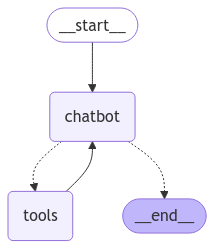

In [15]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [16]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_4g7jfHWwPZezXLaL5y5wepCG)
 Call ID: call_4g7jfHWwPZezXLaL5y5wepCG
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://pypi.org/project/langgraph/", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: # Define the tools for the agent to use # Define the tools for the agent to use # This means that after `tools` is called, `agent` node is called next. workflow.add_edge(\"t

In [17]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_EyKVCfhBBdBzlV9GO6dvUuPR)
 Call ID: call_EyKVCfhBBdBzlV9GO6dvUuPR
  Args:
    name: LangGraph
    birthday: February 6, 2025
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was released on January 17, 2024.


In [18]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

In [24]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="anthropic/claude-3.5-sonnet")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [25]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

I'll search for information about LangGraph to help you learn about it.
Tool Calls:
  tavily_search_results_json (tooluse_n0Cc0S_PT7-4kSjs07f_1w)
 Call ID: tooluse_n0Cc0S_PT7-4kSjs07f_1w
  Args:
    query: LangGraph framework what is it how to use
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applicat

In [26]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

Let me search for some specific information about building autonomous agents with LangGraph.
Tool Calls:
  tavily_search_results_json (tooluse_QJE1dsIoTK-gPonD0HHvRA)
 Call ID: tooluse_QJE1dsIoTK-gPonD0HHvRA
  Args:
    query: how to build autonomous agent LangGraph example tutorial
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@lorevanoudenhove/how-to-build-ai-agents-with-langgraph-a-step-by-step-guide-5d84d9c7e832", "content": "In this step, we’ll define how the AI agent manages its state (the ongoing context of the conversation) and ensure it responds appropriately to the user’s input and tool output. This involves creating a template for the conversation, speci

In [31]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 4:
        to_replay = state

Num Messages:  12 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  11 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  10 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  9 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------

In [32]:
to_replay.next, to_replay.config

(('tools',),
 {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1efee64f-ce99-6b20-8003-be69a0d1521a'}})

In [33]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================



Let me do another search to get more specific information about its features and implementation.
Tool Calls:
  tavily_search_results_json (toolu_vrtx_018mC2s6DNTwTw6Syao3E27L)
 Call ID: toolu_vrtx_018mC2s6DNTwTw6Syao3E27L
  Args:
    query: LangGraph features benefits implementation examples
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/introducing-the-langgraph-functional-api/", "content": "The functional API allows you to leverage LangGraph features using a more traditional programming paradigm, making it easier to build AI workflows that incorporate human-in-the-loop interactions, short-term and long-term memory, and streaming capabilities. But with LangGraph's human-in-the-loop features and Functional API, it's straightforward. LangGraph's built in persistence layer allows you to implement short